***Some parts of the notebook are almost the exact copy of***  https://github.com/yandexdataschool/nlp_course


We are going to implement the model from the [Sequence to Sequence Learning with Neural Networks](https://arxiv.org/abs/1409.3215) paper. 

## Introduction

The most common sequence-to-sequence (seq2seq) models are *encoder-decoder* models, which (commonly) use a *recurrent neural network* (RNN) to *encode* the source (input) sentence into a single vector. In this notebook, we'll refer to this single vector as a *context vector*. You can think of the context vector as being an abstract representation of the entire input sentence. This vector is then *decoded* by a second RNN which learns to output the target (output) sentence by generating it one word at a time.

<img src="https://drive.google.com/uc?id=1ydm_fZdUZIDS2rzDI0qbLLpyzqdo8LpT">

The above image shows an example translation. The input/source sentence, "guten morgen", is input into the encoder (green) one word at a time. We also append a *start of sequence* (`<sos>`) and *end of sequence* (`<eos>`) token to the start and end of sentence, respectively. At each time-step, the input to the encoder RNN is both the current word, $x_t$, as well as the hidden state from the previous time-step, $h_{t-1}$, and the encoder RNN outputs a new hidden state $h_t$. You can think of the hidden state as a vector representation of the sentence so far. The RNN can be represented as a function of both of $x_t$ and $h_{t-1}$:

$$h_t = \text{EncoderRNN}(x_t, h_{t-1})$$

We're using the term RNN generally here, it could be any recurrent architecture, such as an *LSTM* (Long Short-Term Memory) or a *GRU* (Gated Recurrent Unit). 

Here, we have $X = \{x_1, x_2, ..., x_T\}$, where $x_1 = \text{<sos>}, x_2 = \text{guten}$, etc. The initial hidden state, $h_0$, is usually either initialized to zeros or a learned parameter.

Once the final word, $x_T$, has been passed into the RNN, we use the final hidden state, $h_T$, as the context vector, i.e. $h_T = z$. This is a vector representation of the entire source sentence.

Now we have our context vector, $z$, we can start decoding it to get the target sentence, "good morning". Again, we append start and end of sequence tokens to the target sentence. At each time-step, the input to the decoder RNN (blue) is the current word, $y_t$, as well as the hidden state from the previous time-step, $s_{t-1}$, where the initial decoder hidden state, $s_0$, is the context vector, $s_0 = z = h_T$, i.e. the initial decoder hidden state is the final encoder hidden state. Thus, similar to the encoder, we can represent the decoder as:

$$s_t = \text{DecoderRNN}(y_t, s_{t-1})$$

In the decoder, we need to go from the hidden state to an actual word, therefore at each time-step we use $s_t$ to predict (by passing it through a `Linear` layer, shown in purple) what we think is the next word in the sequence, $\hat{y}_t$. 

$$\hat{y}_t = f(s_t)$$

We always use `<sos>` for the first input to the decoder, $y_1$, but for subsequent inputs, $y_{t>1}$, we will sometimes use the actual, ground truth next word in the sequence, $y_t$ and sometimes use the word predicted by our decoder, $\hat{y}_{t-1}$. This is called *teacher forcing*, and you can read about it more [here](https://machinelearningmastery.com/teacher-forcing-for-recurrent-neural-networks/).



### Teacher forcing

Teacher forcing is a method for quickly and efficiently training recurrent neural network models that use the ground truth from a prior time step as input.

<img src="https://miro.medium.com/max/421/1*U3d8D_GnfW13Y3nDgvwJSw.png">

When training/testing our model, we always know how many words are in our target sentence, so we stop generating words once we hit that many. During inference (i.e. real world usage) it is common to keep generating words until the model outputs an `<eos>` token or after a certain amount of words have been generated.

Once we have our predicted target sentence, $\hat{Y} = \{ \hat{y}_1, \hat{y}_2, ..., \hat{y}_T \}$, we compare it against our actual target sentence, $Y = \{ y_1, y_2, ..., y_T \}$, to calculate our loss. We then use this loss to update all of the parameters in our model.



# Neural Machine Translation

Write down some summary on your experiments and illustrate it with convergence plots/metrics and your thoughts. Just like you would approach a real problem.

In [ ]:
! wget https://drive.google.com/uc?id=1NWYqJgeG_4883LINdEjKUr6nLQPY6Yb_ -O data.txt

# Thanks to YSDA NLP course team for the data
# (who thanks tilda and deephack teams for the data in their turn)

--2021-04-02 03:25:22--  https://drive.google.com/uc?id=1NWYqJgeG_4883LINdEjKUr6nLQPY6Yb_
Resolving drive.google.com (drive.google.com)... 172.217.203.113, 172.217.203.138, 172.217.203.139, ...
Connecting to drive.google.com (drive.google.com)|172.217.203.113|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-14-00-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/jpkn8cqm457ho9hfhh3tf5fcquldd4d6/1617333900000/16549096980415837553/*/1NWYqJgeG_4883LINdEjKUr6nLQPY6Yb_ [following]
--2021-04-02 03:25:24--  https://doc-14-00-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/jpkn8cqm457ho9hfhh3tf5fcquldd4d6/1617333900000/16549096980415837553/*/1NWYqJgeG_4883LINdEjKUr6nLQPY6Yb_
Resolving doc-14-00-docs.googleusercontent.com (doc-14-00-docs.googleusercontent.com)... 173.194.215.132, 2607:f8b0:400c:c0c::84
Connecting to doc-14-00-docs.googleusercontent.com (doc-14-00-docs.googleusercontent.com)|1

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

import torchtext
from torchtext.legacy.data import Field, BucketIterator

import spacy

import random
import math
import time
import numpy as np

import matplotlib
matplotlib.rcParams.update({'figure.figsize': (16, 12), 'font.size': 14})
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import clear_output

from nltk.tokenize import WordPunctTokenizer

We'll set the random seeds for deterministic results.

In [ ]:
SEED = 1234

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

## Preparing Data

Here comes the preprocessing

In [ ]:
tokenizer_W = WordPunctTokenizer()

def tokenize_ru(x, tokenizer=tokenizer_W):
    return tokenizer.tokenize(x.lower())[::-1]

def tokenize_en(x, tokenizer=tokenizer_W):
    return tokenizer.tokenize(x.lower())

In [ ]:
SRC = Field(tokenize=tokenize_ru,
            init_token = '<sos>', 
            eos_token = '<eos>', 
            lower = True)

TRG = Field(tokenize=tokenize_en,
            init_token = '<sos>', 
            eos_token = '<eos>', 
            lower = True)


dataset = torchtext.legacy.data.TabularDataset(
    path='data.txt',
    format='tsv',
    fields=[('trg', TRG), ('src', SRC)]
)

In [ ]:
print(len(dataset.examples))
print(dataset.examples[0].src)
print(dataset.examples[0].trg)

50000
['.', 'собора', 'троицкого', '-', 'свято', 'от', 'ходьбы', 'минутах', '3', 'в', ',', 'тбилиси', 'в', 'расположен', 'cordelia', 'отель']
['cordelia', 'hotel', 'is', 'situated', 'in', 'tbilisi', ',', 'a', '3', '-', 'minute', 'walk', 'away', 'from', 'saint', 'trinity', 'church', '.']


In [ ]:
train_data, valid_data, test_data = dataset.split(split_ratio=[0.8, 0.15, 0.05])

print(f"Number of training examples: {len(train_data.examples)}")
print(f"Number of validation examples: {len(valid_data.examples)}")
print(f"Number of testing examples: {len(test_data.examples)}")

Number of training examples: 40000
Number of validation examples: 2500
Number of testing examples: 7500


In [ ]:
SRC.build_vocab(train_data, min_freq = 2)
TRG.build_vocab(train_data, min_freq = 2)

In [ ]:
print(f"Unique tokens in source (ru) vocabulary: {len(SRC.vocab)}")
print(f"Unique tokens in target (en) vocabulary: {len(TRG.vocab)}")

Unique tokens in source (ru) vocabulary: 14129
Unique tokens in target (en) vocabulary: 10104


And here is example from train dataset:

In [ ]:
print(vars(train_data.examples[9]))

{'trg': ['other', 'facilities', 'offered', 'at', 'the', 'property', 'include', 'grocery', 'deliveries', ',', 'laundry', 'and', 'ironing', 'services', '.'], 'src': ['.', 'услуги', 'гладильные', 'и', 'прачечной', 'услуги', ',', 'продуктов', 'доставка', 'предлагается', 'также']}


When we get a batch of examples using an iterator we need to make sure that all of the source sentences are padded to the same length, the same with the target sentences. Luckily, TorchText iterators handle this for us! 

We use a `BucketIterator` instead of the standard `Iterator` as it creates batches in such a way that it minimizes the amount of padding in both the source and target sentences. 

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
def _len_sort_key(x):
    return len(x.src)

BATCH_SIZE = 128

train_iterator, valid_iterator, test_iterator = BucketIterator.splits(
    (train_data, valid_data, test_data), 
    batch_size = BATCH_SIZE, 
    device = device,
    sort_key=_len_sort_key
)

## Encoder

For a multi-layer RNN, the input sentence, $X$, goes into the first (bottom) layer of the RNN and hidden states, $H=\{h_1, h_2, ..., h_T\}$, output by this layer are used as inputs to the RNN in the layer above. Thus, representing each layer with a superscript, the hidden states in the first layer are given by:

$$h_t^1 = \text{EncoderRNN}^1(x_t, h_{t-1}^1)$$

The hidden states in the second layer are given by:

$$h_t^2 = \text{EncoderRNN}^2(h_t^1, h_{t-1}^2)$$

Extending our multi-layer equations to LSTMs, we get:

$$\begin{align*}
(h_t^1, c_t^1) &= \text{EncoderLSTM}^1(x_t, (h_{t-1}^1, c_{t-1}^1))\\
(h_t^2, c_t^2) &= \text{EncoderLSTM}^2(h_t^1, (h_{t-1}^2, c_{t-1}^2))
\end{align*}$$

<br><br>
<img src="https://drive.google.com/uc?id=1uIUxtZU8NvGdz0J9BlRSTbsBLFh32rxx">

In [ ]:
class Encoder(nn.Module):
    def __init__(self, input_dim, emb_dim, hid_dim, n_layers, dropout, bidirectional):
        super().__init__()
        
        self.input_dim = input_dim
        self.emb_dim = emb_dim
        self.hid_dim = hid_dim
        self.n_layers = n_layers
        self.dropout = dropout
        self.bidirectional = bidirectional
        
        self.embedding = nn.Embedding(input_dim, emb_dim)
        
        self.rnn = nn.LSTM(emb_dim, hid_dim, num_layers=n_layers, dropout=dropout, bidirectional=bidirectional)
        
        self.dropout = nn.Dropout(p=dropout)
        
    def forward(self, src):
        
        #src = [src sent len, batch size]
        
        # Compute an embedding from the src data and apply dropout to it
        embedded = self.dropout(self.embedding(src))
        
        #embedded = [src sent len, batch size, emb dim]
        
        # Compute the RNN output values of the encoder RNN. 
        # outputs, hidden and cell should be initialized here. Refer to nn.LSTM docs ;)
        
        _, (hidden, cell) = self.rnn(embedded)
        
        #outputs = [src sent len, batch size, hid dim * n directions]
        #hidden = [n layers * n directions, batch size, hid dim]
        #cell = [n layers * n directions, batch size, hid dim]
        
        #outputs are always from the top hidden layer
        if self.bidirectional:
            #print(hidden.shape)
            hidden = hidden.reshape(self.n_layers, 2, -1, self.hid_dim)
            hidden = hidden.transpose(1, 2).reshape(self.n_layers, -1, 2 * self.hid_dim)

            cell = cell.reshape(self.n_layers, 2, -1, self.hid_dim)
            cell = cell.transpose(1, 2).reshape(self.n_layers, -1, 2 * self.hid_dim)
            #print(hidden.shape)
        return hidden, cell

## Decoder

The `Decoder` class does a single step of decoding. The first layer will receive a hidden and cell state from the previous time-step, $(s_{t-1}^1, c_{t-1}^1)$, and feed it through the LSTM with the current token, $y_t$, to produce a new hidden and cell state, $(s_t^1, c_t^1)$. The subsequent layers will use the hidden state from the layer below, $s_t^{l-1}$, and the previous hidden and cell states from their layer, $(s_{t-1}^l, c_{t-1}^l)$. This provides equations very similar to those in the encoder.

$$\begin{align*}
(s_t^1, c_t^1) = \text{DecoderLSTM}^1(y_t, (s_{t-1}^1, c_{t-1}^1))\\
(s_t^2, c_t^2) = \text{DecoderLSTM}^2(s_t^1, (s_{t-1}^2, c_{t-1}^2))
\end{align*}$$

Remember that the initial hidden and cell states to our decoder are our context vectors, which are the final hidden and cell states of our encoder from the same layer, i.e. $(s_0^l,c_0^l)=z^l=(h_T^l,c_T^l)$.

We then pass the hidden state from the top layer of the RNN, $s_t^L$, through a linear layer, $f$, to make a prediction of what the next token in the target (output) sequence should be, $\hat{y}_{t+1}$. 

$$\hat{y}_{t+1} = f(s_t^L)$$

<img src="https://drive.google.com/uc?id=1EX5ygi09wY6LA0T5R0pjGpfxoC0Q5m6W">

In [ ]:
class Decoder(nn.Module):
    def __init__(self, output_dim, emb_dim, hid_dim, n_layers, dropout):
        super().__init__()

        self.emb_dim = emb_dim
        self.hid_dim = hid_dim
        self.output_dim = output_dim
        self.n_layers = n_layers
        self.dropout = dropout
        
        self.embedding = nn.Embedding(output_dim, emb_dim)
        
        self.rnn = nn.LSTM(emb_dim, hid_dim, num_layers=n_layers, dropout=dropout)
        
        self.out = nn.Linear(hid_dim, output_dim)
        
        self.dropout = nn.Dropout(p=dropout)
        
    def forward(self, input, hidden, cell):
        
        #input = [batch size]
        #hidden = [n layers * n directions, batch size, hid dim]
        #cell = [n layers * n directions, batch size, hid dim]
        
        #n directions in the decoder will both always be 1, therefore:
        #hidden = [n layers, batch size, hid dim]
        #context = [n layers, batch size, hid dim]
        
        input = input.unsqueeze(0)
        
        #input = [1, batch size]
        
        # Compute an embedding from the input data and apply dropout to it
        embedded = self.dropout(self.embedding(input))
        
        #embedded = [1, batch size, emb dim]
        
        # Compute the RNN output values of the encoder RNN. 
        # outputs, hidden and cell should be initialized here. Refer to nn.LSTM docs ;)
        output, (hidden, cell) = self.rnn(embedded, (hidden, cell))
        
        
        #output = [sent len, batch size, hid dim * n directions]
        #hidden = [n layers * n directions, batch size, hid dim]
        #cell = [n layers * n directions, batch size, hid dim]
        
        #sent len and n directions will always be 1 in the decoder, therefore:
        #output = [1, batch size, hid dim]
        #hidden = [n layers, batch size, hid dim]
        #cell = [n layers, batch size, hid dim]
        
        prediction = self.out(output.squeeze(0))
        
        #prediction = [batch size, output dim]
        
        return prediction, hidden, cell

## Seq2Seq

Our `forward` method takes the source sentence, target sentence and a teacher-forcing ratio. The teacher forcing ratio is used when training our model. When decoding, at each time-step we will predict what the next token in the target sequence will be from the previous tokens decoded, $\hat{y}_{t+1}=f(s_t^L)$. With probability equal to the teaching forcing ratio (`teacher_forcing_ratio`) we will use the actual ground-truth next token in the sequence as the input to the decoder during the next time-step. However, with probability `1 - teacher_forcing_ratio`, we will use the token that the model predicted as the next input to the model, even if it doesn't match the actual next token in the sequence.  

The first thing we do in the `forward` method is to create an `outputs` tensor that will store all of our predictions, $\hat{Y}$.

We then feed the input/source sentence, $X$/`src`, into the encoder and receive out final hidden and cell states.

The first input to the decoder is the start of sequence (`<sos>`) token. As our `trg` tensor already has the `<sos>` token appended (all the way back when we defined the `init_token` in our `TRG` field) we get our $y_1$ by slicing into it. We know how long our target sentences should be (`max_len`), so we loop that many times. During each iteration of the loop, we:
- pass the input, previous hidden and previous cell states ($y_t, s_{t-1}, c_{t-1}$) into the decoder
- receive a prediction, next hidden state and next cell state ($\hat{y}_{t+1}, s_{t}, c_{t}$) from the decoder
- place our prediction, $\hat{y}_{t+1}$/`output` in our tensor of predictions, $\hat{Y}$/`outputs`
- decide if we are going to "teacher force" or not
    - if we do, the next `input` is the ground-truth next token in the sequence, $y_{t+1}$/`trg[t]`
    - if we don't, the next `input` is the predicted next token in the sequence, $\hat{y}_{t+1}$/`top1`
    
Once we've made all of our predictions, we return our tensor full of predictions, $\hat{Y}$/`outputs`.



<img src="https://drive.google.com/uc?id=1pPDuLqr9Qrldthkbm7-Cqp3uOJSg7MR-">

**Note**: our decoder loop starts at 1, not 0. This means the 0th element of our `outputs` tensor remains all zeros. So our `trg` and `outputs` look something like:

$$\begin{align*}
\text{trg} = [<sos>, &y_1, y_2, y_3, <eos>]\\
\text{outputs} = [0, &\hat{y}_1, \hat{y}_2, \hat{y}_3, <eos>]
\end{align*}$$

Later on when we calculate the loss, we cut off the first element of each tensor to get:

$$\begin{align*}
\text{trg} = [&y_1, y_2, y_3, <eos>]\\
\text{outputs} = [&\hat{y}_1, \hat{y}_2, \hat{y}_3, <eos>]
\end{align*}$$

In [ ]:
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, device):
        super().__init__()
        
        self.encoder = encoder
        self.decoder = decoder
        self.device = device
        
        if encoder.bidirectional:
            assert encoder.hid_dim * 2 == decoder.hid_dim, \
                "Hidden dimensions of encoder and decoder must be equal!"
        else:
            assert encoder.hid_dim == decoder.hid_dim, \
                    "Hidden dimensions of encoder and decoder must be equal!"
        assert encoder.n_layers == decoder.n_layers, \
            "Encoder and decoder must have equal number of layers!"
        
    def forward(self, src, trg, teacher_forcing_ratio = 0.5):
        
        #src = [src len, batch size]
        #trg = [trg len, batch size]
        #teacher_forcing_ratio is probability to use teacher forcing
        #e.g. if teacher_forcing_ratio is 0.75 we use ground-truth inputs 75% of the time
        
        batch_size = trg.shape[1]
        trg_len = trg.shape[0]
        trg_vocab_size = self.decoder.output_dim
        
        #tensor to store decoder outputs
        outputs = torch.zeros(trg_len, batch_size, trg_vocab_size).to(self.device)
        
        #last hidden state of the encoder is used as the initial hidden state of the decoder
        hidden, cell = self.encoder(src)
        
        #first input to the decoder is the <sos> tokens
        input = trg[0,:]
        
        for t in range(1, trg_len):
            
            #insert input token embedding, previous hidden and previous cell states
            #receive output tensor (predictions) and new hidden and cell states
            output, hidden, cell = self.decoder(input, hidden, cell)
            #place predictions in a tensor holding predictions for each token
            outputs[t] = output
            #decide if we are going to use teacher forcing or not
            teacher_force = random.random() < teacher_forcing_ratio
            #get the highest predicted token from our predictions
            top1 = output.argmax(-1) 
            #if teacher forcing, use actual next token as next input
            #if not, use predicted token
            input = trg[t] if teacher_force else top1
        
        return outputs

## Training

In [ ]:
# For reloading 
# import modules
# import imp
# imp.reload(modules)

# Encoder = modules.Encoder
# Attention = modules.Attention
# Decoder = modules.DecoderWithAttention
# Seq2Seq = modules.Seq2Seq

INPUT_DIM = len(SRC.vocab)
OUTPUT_DIM = len(TRG.vocab)
ENC_EMB_DIM = 256
DEC_EMB_DIM = 256
HID_DIM = 512
N_LAYERS = 2
ENC_DROPOUT = 0.5
DEC_DROPOUT = 0.5
BIDIRECTIONAL = True

enc = Encoder(INPUT_DIM, ENC_EMB_DIM, HID_DIM // 2, N_LAYERS, ENC_DROPOUT, BIDIRECTIONAL)
dec = Decoder(OUTPUT_DIM, DEC_EMB_DIM, HID_DIM, N_LAYERS, DEC_DROPOUT)

# dont forget to put the model to the right device
model = Seq2Seq(enc, dec, device).to(device)

In [ ]:
def init_weights(m):
    for name, param in m.named_parameters():
        nn.init.uniform_(param, -0.08, 0.08)
        
model.apply(init_weights)

Seq2Seq(
  (encoder): Encoder(
    (embedding): Embedding(14129, 256)
    (rnn): LSTM(256, 256, num_layers=2, dropout=0.5, bidirectional=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (decoder): Decoder(
    (embedding): Embedding(10104, 256)
    (rnn): LSTM(256, 512, num_layers=2, dropout=0.5)
    (out): Linear(in_features=512, out_features=10104, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
)

In [ ]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 17,694,840 trainable parameters


In [ ]:
PAD_IDX = TRG.vocab.stoi['<pad>']
optimizer = optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss(ignore_index = PAD_IDX)

def train(model, iterator, optimizer, criterion, clip, train_history=None, valid_history=None):
    model.train()
    
    epoch_loss = 0
    history = []
    for i, batch in enumerate(iterator):
        
        src = batch.src
        trg = batch.trg
        
        optimizer.zero_grad()
        
        output = model(src, trg)
        
        #trg = [trg sent len, batch size]
        #output = [trg sent len, batch size, output dim]
        
        output = output[1:].view(-1, OUTPUT_DIM)
        trg = trg[1:].view(-1)
        
        #trg = [(trg sent len - 1) * batch size]
        #output = [(trg sent len - 1) * batch size, output dim]
        
        loss = criterion(output, trg)
        
        loss.backward()
        
        # Let's clip the gradient
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        
        optimizer.step()
        
        epoch_loss += loss.item()
        
        history.append(loss.cpu().data.numpy())
        if (i+1)%10==0:
            fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 8))

            clear_output(True)
            ax[0].plot(history, label='train loss')
            ax[0].set_xlabel('Batch')
            ax[0].set_title('Train loss')
            if train_history is not None:
                ax[1].plot(train_history, label='general train history')
                ax[1].set_xlabel('Epoch')
            if valid_history is not None:
                ax[1].plot(valid_history, label='general valid history')
            plt.legend()
            
            plt.show()

        
    return epoch_loss / len(iterator)

def evaluate(model, iterator, criterion):
    
    model.eval()
    
    epoch_loss = 0
    
    history = []
    
    with torch.no_grad():
    
        for i, batch in enumerate(iterator):

            src = batch.src
            trg = batch.trg

            output = model(src, trg, 0) #turn off teacher forcing

            #trg = [trg sent len, batch size]
            #output = [trg sent len, batch size, output dim]

            output = output[1:].view(-1, OUTPUT_DIM)
            trg = trg[1:].view(-1)

            #trg = [(trg sent len - 1) * batch size]
            #output = [(trg sent len - 1) * batch size, output dim]

            loss = criterion(output, trg)
            
            epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [ ]:
import matplotlib
matplotlib.rcParams.update({'figure.figsize': (16, 12), 'font.size': 14})
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import clear_output

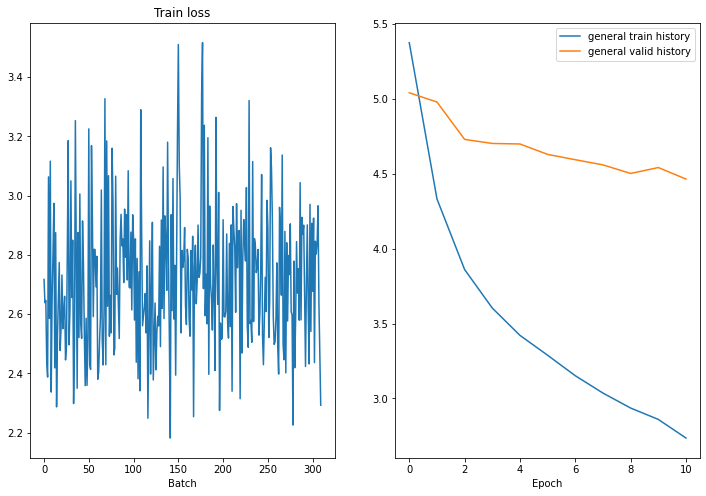

Epoch: 12 | Time: 1m 37s
	Train Loss: 2.716 | Train PPL:  15.117
	 Val. Loss: 4.503 |  Val. PPL:  90.278


In [ ]:
train_history = []
valid_history = []

N_EPOCHS = 12
CLIP = 5

best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):
    
    start_time = time.time()
    
    train_loss = train(model, train_iterator, optimizer, criterion, CLIP, train_history, valid_history)
    valid_loss = evaluate(model, valid_iterator, criterion)
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'best-val-model.pt')
    
    train_history.append(train_loss)
    valid_history.append(valid_loss)
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')

__Let's take a look at our network quality__:

In [ ]:
def cut_on_eos(tokens_iter):
    for token in tokens_iter:
        if token == '<eos>':
            break
        yield token

def remove_tech_tokens(tokens_iter, tokens_to_remove=['<sos>', '<unk>', '<pad>']):
    return [x for x in tokens_iter if x not in tokens_to_remove]

def generate_translation(src, trg, model, TRG_vocab):
    model.eval()

    output = model(src, trg, 0) #turn off teacher forcing
    output = output[1:].argmax(-1)

    original = remove_tech_tokens(cut_on_eos([TRG_vocab.itos[x] for x in list(trg[:,0].cpu().numpy())]))
    generated = remove_tech_tokens(cut_on_eos([TRG_vocab.itos[x] for x in list(output[:, 0].cpu().numpy())]))
    
    print('Original: {}'.format(' '.join(original)))
    print('Generated: {}'.format(' '.join(generated)))
    print()

def get_text(x, TRG_vocab):
     generated = remove_tech_tokens(cut_on_eos([TRG_vocab.itos[elem] for elem in list(x)]))
     return generated

In [ ]:
model.load_state_dict(torch.load('best-val-model.pt'))
batch = next(iter(test_iterator))

for idx in range(10):
    src = batch.src[:, idx:idx+1]
    trg = batch.trg[:, idx:idx+1]
    generate_translation(src, trg, model, TRG.vocab)

Original: there is a 24 - hour front desk at the property .
Generated: you will find a 24 - hour front desk at the property .

Original: you will find a 24 - hour front desk at the property .
Generated: you will find a 24 - hour front desk at the property .

Original: there is a 24 - hour front desk at the property .
Generated: you will find a 24 - hour front desk at the property .

Original: free private parking is available .
Generated: free private parking is available on site .

Original: there are several restaurants in the surrounding area .
Generated: restaurants and restaurants can be found in the surrounding area .

Original: the property also offers free parking .
Generated: the property offers free parking .

Original: the unit is fitted with a kitchen .
Generated: the unit is equipped with a kitchen .

Original: the bathroom has a shower .
Generated: private bathroom with shower .

Original: there is also a fireplace in the living room .
Generated: the living room comes wit

## Bleu

[link](https://www.aclweb.org/anthology/P02-1040.pdf)

<img src="https://drive.google.com/uc?id=1umJF2S8PiayxD9Xo8xvjW8QsrSLidozD" height=400>

In [ ]:
from nltk.translate.bleu_score import corpus_bleu

#     """ Estimates corpora-level BLEU score of model's translations given inp and reference out """
#     translations, _ = model.translate_lines(inp_lines, **flags)
#     # Note: if you experience out-of-memory error, split input lines into batches and translate separately
#     return corpus_bleu([[ref] for ref in out_lines], translations) * 100

In [ ]:
import tqdm
original_text = []
generated_text = []
model.eval()
with torch.no_grad():

    for i, batch in tqdm.tqdm(enumerate(test_iterator)):

        src = batch.src
        trg = batch.trg

        output = model(src, trg, 0) #turn off teacher forcing

        #trg = [trg sent len, batch size]
        #output = [trg sent len, batch size, output dim]

        output = output[1:].argmax(-1)
        
        original_text.extend([get_text(x, TRG.vocab) for x in trg.cpu().numpy().T])
        generated_text.extend([get_text(x, TRG.vocab) for x in output.detach().cpu().numpy().T])

# original_text = flatten(original_text)
# generated_text = flatten(generated_text)

59it [00:04, 13.15it/s]


In [ ]:
corpus_bleu([[text] for text in original_text], generated_text) * 100

18.953009449126917